In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to your local databases (adjust path if needed)
options_conn = sqlite3.connect('../sql-database/options.db')
stocks_conn = sqlite3.connect('../sql-database/stocks.db')

Matplotlib is building the font cache; this may take a moment.


In [4]:
options_conn = sqlite3.connect('../sql-database/options.db')

In [5]:
import os
os.path.exists('../sql-database/options.db')

True

In [7]:
tables = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table';", options_conn)
print(tables)

Empty DataFrame
Columns: [name]
Index: []


In [9]:
import sqlite3
import pandas as pd

# Reconnect
options_conn = sqlite3.connect('../sql-database/options_data.db')
stocks_conn = sqlite3.connect('../sql-database/stocks_data.db')

# List tables
print(pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", options_conn))

# Preview data
print(pd.read_sql("SELECT * FROM options LIMIT 5;", options_conn))


      name
0  options
           contract underlying  expiration  type  strike style   bid bid_size  \
0  A130420C00034000          A  2013-04-20  call    34.0     A  6.55     None   
1  A130420P00034000          A  2013-04-20   put    34.0     A  0.01     None   
2  A130420C00035000          A  2013-04-20  call    35.0     A  5.55     None   
3  A130420P00035000          A  2013-04-20   put    35.0     A  0.02     None   
4  A130420C00036000          A  2013-04-20  call    36.0     A  5.30     None   

    ask ask_size  volume  open_interest  quote_date   delta   gamma   theta  \
0  9.40     None       0              0  2013-03-27  0.9982  0.0002  1.0139   
1  0.06     None       0              0  2013-03-27 -0.0174  0.0099 -1.4750   
2  8.65     None       0              0  2013-03-27  0.9975  0.0011  0.9680   
3  0.05     None       0             24  2013-03-27 -0.0219  0.0134 -1.6229   
4  6.25     None       0              0  2013-03-27  0.9946  0.0045  0.8018   

     vega  impli

In [10]:
print(pd.read_sql("SELECT * FROM stocks LIMIT 5;", stocks_conn))

  symbol       open       high        low      close    volume adjust_close  \
0      A  42.450000  42.759999  41.630001  41.650000   6163900         None   
1     AA   8.499991   8.539991   8.449991   8.449991   2967700         None   
2   AACC   6.490000   6.505000   6.460000   6.470000    598100         None   
3  AAMRQ   4.290000   4.470000   4.280000   4.380000  12506800         None   
4    AAN  28.660000  28.780001  28.160000  28.350000    319900         None   

   quote_date  
0  2013-03-21  
1  2013-03-21  
2  2013-03-21  
3  2013-03-21  
4  2013-03-21  


In [13]:
pd.read_sql("SELECT COUNT(*) FROM options;", options_conn)

,COUNT(*)
0,128230452


In [12]:
pd.read_sql("SELECT COUNT(*) FROM stocks;", stocks_conn)

,COUNT(*)
0,958972


In [34]:
import os, math, sqlite3, pandas as pd
from datetime import datetime, timedelta
from scipy.stats import norm

DB_DIR   = "../sql-database"        # ←-- update if different
OPT_DB   = os.path.join(DB_DIR, "options_data.db")
STK_DB   = os.path.join(DB_DIR, "stocks_data.db")

# --- Black-Scholes European put --------------------------------------------
def bs_put(S, K, T, r, sigma):
    if min(S, K, T, sigma) <= 0:         # catch bad inputs
        return 0.0
    d1 = (math.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    return K*math.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# ---------------------------------------------------------------------------
def weekly_put_screen(start_date="2013-01-07", weeks=4,r=0.05, lookback_days=10, top_n=20):
    """
    Return a DataFrame of the top‐N puts (most under-priced to buy /
    most over-priced to sell) for each Monday–Friday week.
    """
    opt_con  = sqlite3.connect(OPT_DB)
    stk_con  = sqlite3.connect(STK_DB)

    start    = datetime.strptime(start_date, "%Y-%m-%d")
    mondays  = [start + timedelta(weeks=i) for i in range(weeks)]
    T        = 5/365                     # Monday → Friday, ~5 trading days
    rows     = []

    for monday in mondays:
        monday_str = monday.strftime("%Y-%m-%d")

        # 1️⃣  load Monday stock closes
        stk = pd.read_sql(f"""
            SELECT symbol, close
            FROM   stocks
            WHERE  quote_date = '{monday_str}'
        """, stk_con)

        # 2️⃣  load Monday puts
        puts = pd.read_sql(f"""
            SELECT *
            FROM   options
            WHERE  quote_date = '{monday_str}'
            AND    type       = 'put'
        """, opt_con)

        if puts.empty or stk.empty:
            continue

        # 3️⃣  merge to get underlying close
        df = puts.merge(stk, left_on="underlying",
                        right_on="symbol")

        # 4️⃣  quick volatility lookup (10 previous closes)
        sig_lookup = {}
        for sym in df["underlying"].unique():
            hist = pd.read_sql(f"""
                SELECT close
                FROM   stocks
                WHERE  symbol = '{sym}'
                AND    quote_date <= '{monday_str}'
                ORDER BY quote_date DESC
                LIMIT  {lookback_days}
            """, stk_con)
            if len(hist) > 1:
                ret  = hist["close"].pct_change().dropna()
                sig  = ret.std() * math.sqrt(252)
                sig_lookup[sym] = sig

        # 5️⃣  compute edge and collect
        for _, row in df.iterrows():
            S, K   = row["close"], row["strike"]
            bid    = row["bid"]
            sig    = sig_lookup.get(row["underlying"])
            if sig is None or bid <= 0:
                continue
            model  = bs_put(S, K, T, r, sig)
            edge   = model - bid                # >0 → undervalued / good buy
            rows.append({
                "week"        : monday_str,
                "ticker"      : row["underlying"],
                "strike"      : K,
                "stock_close" : S,
                "market_bid"  : bid,
                "bs_price"    : round(model, 2),
                "edge"        : round(edge, 2),
                "sigma"       : round(sig, 4)
            })

    opt_con.close(); stk_con.close()

    # 6️⃣  rank inside each week & keep top-N
    out = (pd.DataFrame(rows)
           .sort_values(["week", "edge"], ascending=[True, False])
           .groupby("week")
           .head(top_n)
           .reset_index(drop=True))
    return out

In [35]:
top_puts = weekly_put_screen(start_date="2013-01-07", weeks=1, top_n=20)
top_puts

,week,ticker,strike,stock_close,market_bid,bs_price,edge,sigma
0,2013-01-07,OEX,690.0,1.245,26.6,688.28,661.68,0.1461
1,2013-01-07,OEX,690.0,1.245,26.6,688.28,661.68,0.1461
2,2013-01-07,OEX,690.0,1.245,26.6,688.28,661.68,0.1461
3,2013-01-07,OEX,690.0,1.245,26.6,688.28,661.68,0.1461
4,2013-01-07,OEX,680.0,1.245,16.7,678.29,661.59,0.1461
5,2013-01-07,OEX,680.0,1.245,16.7,678.29,661.59,0.1461
6,2013-01-07,OEX,680.0,1.245,16.7,678.29,661.59,0.1461
7,2013-01-07,OEX,680.0,1.245,16.7,678.29,661.59,0.1461
8,2013-01-07,OEX,675.0,1.245,11.8,673.29,661.49,0.1461
9,2013-01-07,OEX,675.0,1.245,11.8,673.29,661.49,0.1461


In [ ]:
import sqlite3, pandas as pd, math
from datetime import datetime, timedelta

# ------------------------------------------------------------------
# 1️⃣  Absolute paths to your databases  (update if needed)
OPTIONS_DB = "../sql-database/options_data.db"
STOCKS_DB  = "../sql-database/stocks_data.db"

# 2️⃣  top_puts must already exist (produced by weekly_put_screen)
assert 'top_puts' in globals(), \
       "Run weekly_put_screen first so `top_puts` exists."

opt_con = sqlite3.connect(OPTIONS_DB)
stk_con = sqlite3.connect(STOCKS_DB)

records = []

for _, row in top_puts.iterrows():
    week_start = datetime.strptime(row['week'], "%Y-%m-%d")
    friday     = week_start + timedelta(days=4)
    fri_str    = friday.strftime("%Y-%m-%d")

    # Friday close
    q = f"""
        SELECT close FROM stocks
        WHERE symbol = '{row['ticker']}'
          AND quote_date = '{fri_str}'
        LIMIT 1
    """
    fri_price = pd.read_sql(q, stk_con)
    if fri_price.empty:
        continue                      # skip if Friday data missing
    S_fri = fri_price.iloc[0]['close']

    # Payoff for *buying* the put (positive if ITM)
    payoff = max(0, row['strike'] - S_fri)
    pnl    = payoff - row['market_price']   # cost was the bid you paid
    assigned = S_fri < row['strike']

    records.append({
        **row.to_dict(),
        "friday"   : fri_str,
        "S_fri"    : S_fri,
        "payoff"   : payoff,
        "PnL"      : pnl,
        "assigned" : assigned
    })

exercise_df = pd.DataFrame(records)

# ------------------------------------------------------------------
# 3️⃣  Week-by-week summary
summary_df = (exercise_df.groupby('week')
              .agg(total_picks   = ('ticker','count'),
                   assignments   = ('assigned','sum'),
                   avg_pnl       = ('PnL','mean'),
                   total_pnl     = ('PnL','sum'))
              .reset_index())

# ------------------------------------------------------------------
# 4️⃣  Show / return results
exercise_df.head(), summary_df


In [37]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.


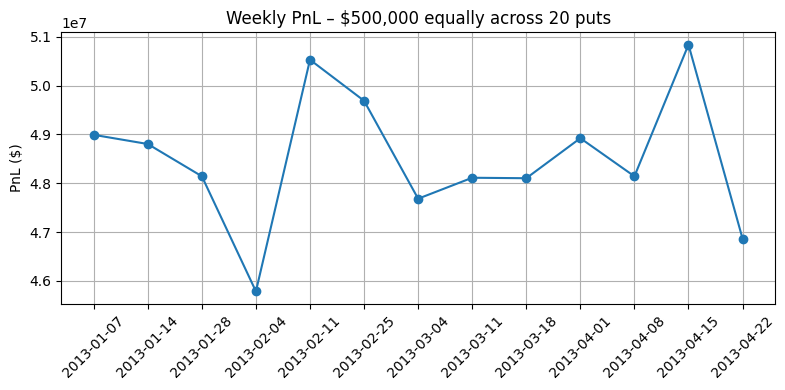

,week,weekly_PnL
0,2013-01-07,4.899026e+07
1,2013-01-14,4.880212e+07
2,2013-01-28,4.814124e+07
3,2013-02-04,4.578380e+07
4,2013-02-11,5.052793e+07
5,2013-02-25,4.968777e+07
6,2013-03-04,4.768203e+07
7,2013-03-11,4.811116e+07
8,2013-03-18,4.810141e+07
9,2013-04-01,4.892133e+07


In [41]:
import importlib, sp500_put_scanner as scan
importlib.reload(scan)                           # reload if you edit the file

# 1️⃣ Top 20 puts each Monday (Jan 2013, 4 weeks)
top_puts = scan.weekly_put_screen("2013-01-07", weeks=16, top_n=20)
top_puts.head()

# 2️⃣ Back-test Monday→Friday performance
bt = scan.backtest_puts(top_puts)
bt.head()

# 3️⃣ Plot weekly PnL assuming $500k spread equally
scan.plot_weekly_pnl(bt, capital=500_000, picks_per_week=20)

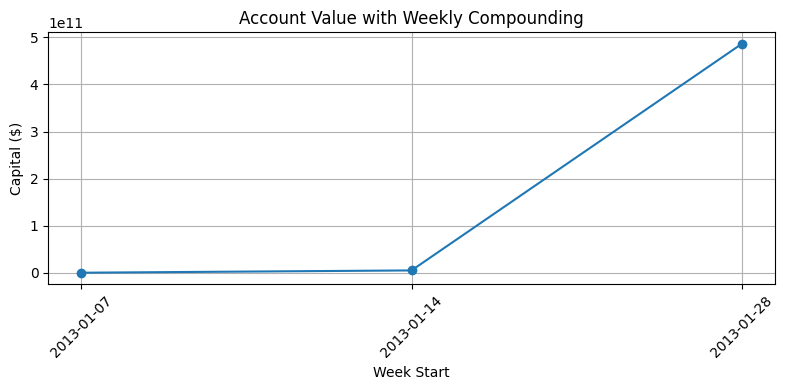


Final capital: $486,318,387,831.32


,week,starting_capital,weekly_PnL,ending_capital
0,2013-01-07,5.000000e+05,4.899026e+07,4.949026e+07
1,2013-01-14,4.949026e+07,4.879907e+09,4.929398e+09
2,2013-01-28,4.929398e+09,4.813890e+11,4.863184e+11


In [42]:
import importlib, sp500_put_scanner as scan
importlib.reload(scan)                    # if you pasted the new fn

top_puts = scan.weekly_put_screen("2013-01-07", weeks=4, top_n=20)
bt       = scan.backtest_puts(top_puts)
ledger   = scan.plot_weekly_pnl_cmpd(bt, starting_capital=500_000, picks_per_week=20)

ledger.head()      # shows weekly start, PnL, ending cap


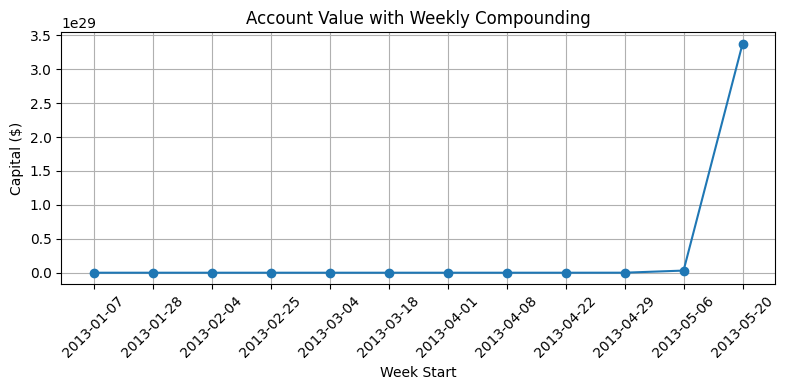


Final capital: $337,423,096,538,312,704,870,620,069,888.00


,week,starting_capital,weekly_PnL,ending_capital
0,2013-01-07,5.000000e+05,4.992850e+07,5.042850e+07
1,2013-01-28,5.042850e+07,4.873977e+09,4.924406e+09
2,2013-02-04,4.924406e+09,3.907294e+11,3.956538e+11
3,2013-02-25,3.956538e+11,4.205489e+13,4.245054e+13
4,2013-03-04,4.245054e+13,4.218350e+15,4.260801e+15


In [45]:
import importlib, sp500_put_scanner as scan
importlib.reload(scan)                    # if you pasted the new fn

top_puts = scan.weekly_put_screen_aggregate("2013-01-07", weeks=20, top_n=20)
bt       = scan.backtest_puts(top_puts)
ledger   = scan.plot_weekly_pnl_cmpd(bt, starting_capital=500_000, picks_per_week=20)

ledger.head()      # shows weekly start, PnL, ending cap


In [46]:
# ── print each week’s 20 names neatly ──────────────────────────
for wk, grp in top_puts.groupby("week"):
    print(f"\n=== {wk}  (Top 20 Puts) ===")
    display(grp[["ticker", "strike", "stock_close",
                 "market_bid", "bs_price", "edge"]].reset_index(drop=True))


=== 2013-01-07  (Top 20 Puts) ===


,ticker,strike,stock_close,market_bid,bs_price,edge
0,AAPL,630.0,523.900002,1.0565,105.75,104.70
1,AAPL,625.0,523.900002,1.0020,100.76,99.76
2,AAPL,620.0,523.900002,0.9535,95.76,94.81
3,AAPL,615.0,523.900002,0.9040,90.76,89.86
4,AAPL,610.0,523.900002,0.8535,85.77,84.91
5,CMG,385.0,299.589996,0.8350,85.20,84.36
6,AAPL,605.0,523.900002,0.8020,80.77,79.97
7,CMG,380.0,299.589996,0.7850,80.20,79.42
8,CF,290.0,210.090008,0.7815,79.75,78.97
9,AAPL,600.0,523.900002,0.7565,75.77,75.01



=== 2013-01-28  (Top 20 Puts) ===


,ticker,strike,stock_close,market_bid,bs_price,edge
0,AAPL,650.0,449.830002,1.9935,199.81,197.82
1,AAPL,640.0,449.830002,1.8935,189.82,187.93
2,AAPL,630.0,449.830002,1.7935,179.83,178.03
3,AAPL,620.0,449.830002,1.6940,169.83,168.14
4,AAPL,610.0,449.830002,1.5940,159.84,158.24
5,AAPL,600.0,449.830002,1.4935,149.84,148.35
6,AAPL,595.0,449.830002,1.4445,144.85,143.40
7,AAPL,590.0,449.830002,1.3935,139.85,138.46
8,AAPL,585.0,449.830002,1.3435,134.86,133.51
9,AAPL,580.0,449.830002,1.2950,129.86,128.57



=== 2013-02-04  (Top 20 Puts) ===


,ticker,strike,stock_close,market_bid,bs_price,edge
0,AAPL,610.0,442.320004,1.6955,167.35,165.65
1,AAPL,600.0,442.320004,1.5930,157.35,155.76
2,AAPL,590.0,442.320004,1.4935,147.36,145.86
3,AAPL,580.0,442.320004,1.3970,137.36,135.97
4,AAPL,570.0,442.320004,1.3000,127.37,126.07
5,AAPL,565.0,442.320004,1.2440,122.37,121.13
6,AAPL,560.0,442.320004,1.1940,117.37,116.18
7,AAPL,555.0,442.320004,1.1440,112.38,111.23
8,AAPL,550.0,442.320004,1.1000,107.38,106.28
9,AAPL,545.0,442.320004,1.0430,102.38,101.34



=== 2013-02-25  (Top 20 Puts) ===


,ticker,strike,stock_close,market_bid,bs_price,edge
0,AAPL,610.0,442.799988,1.6670,166.87,165.20
1,AAPL,600.0,442.799988,1.5670,156.87,155.30
2,AAPL,590.0,442.799988,1.4670,146.88,145.41
3,AAPL,580.0,442.799988,1.3670,136.88,135.52
4,AAPL,575.0,442.799988,1.3170,131.89,130.57
5,AAPL,570.0,442.799988,1.2670,126.89,125.62
6,AAPL,565.0,442.799988,1.2175,121.89,120.67
7,AAPL,560.0,442.799988,1.1665,116.89,115.73
8,AAPL,555.0,442.799988,1.1170,111.90,110.78
9,AAPL,550.0,442.799988,1.0665,106.90,105.83



=== 2013-03-04  (Top 20 Puts) ===


,ticker,strike,stock_close,market_bid,bs_price,edge
0,AAPL,610.0,420.049988,1.8855,189.62,187.73
1,AAPL,600.0,420.049988,1.7855,179.62,177.84
2,AAPL,590.0,420.049988,1.6840,169.63,167.94
3,AAPL,580.0,420.049988,1.5860,159.63,158.05
4,AAPL,570.0,420.049988,1.4860,149.64,148.15
5,AAPL,565.0,420.049988,1.4365,144.64,143.20
6,AAPL,560.0,420.049988,1.3865,139.64,138.26
7,AAPL,555.0,420.049988,1.3370,134.65,133.31
8,AAPL,550.0,420.049988,1.2990,129.65,128.35
9,AAPL,545.0,420.049988,1.2365,124.65,123.41



=== 2013-03-18  (Top 20 Puts) ===


,ticker,strike,stock_close,market_bid,bs_price,edge
0,AAPL,600.0,455.720016,1.4345,143.95,142.52
1,AAPL,590.0,455.720016,1.3330,133.96,132.62
2,AAPL,580.0,455.720016,1.2215,123.96,122.74
3,AAPL,575.0,455.720016,1.1700,118.97,117.80
4,AAPL,570.0,455.720016,1.1215,113.97,112.85
5,NFLX,295.0,185.590002,1.0785,109.25,108.17
6,ISRG,595.0,485.519989,1.0730,109.15,108.08
7,AAPL,565.0,455.720016,1.0845,108.97,107.89
8,NFLX,290.0,185.590002,1.0290,104.25,103.22
9,ISRG,590.0,485.519989,1.0230,104.16,103.14



=== 2013-04-01  (Top 20 Puts) ===


,ticker,strike,stock_close,market_bid,bs_price,edge
0,AAPL,600.0,428.910004,1.6955,170.76,169.07
1,AAPL,595.0,428.910004,1.6455,165.76,164.12
2,AAPL,590.0,428.910004,1.5955,160.77,159.17
3,AAPL,585.0,428.910004,1.5455,155.77,154.22
4,AAPL,580.0,428.910004,1.4955,150.77,149.28
5,AAPL,575.0,428.910004,1.4455,145.78,144.33
6,AAPL,570.0,428.910004,1.4010,140.78,139.38
7,AAPL,565.0,428.910004,1.3590,135.78,134.42
8,AAPL,560.0,428.910004,1.2955,130.78,129.49
9,AAPL,555.0,428.910004,1.2510,125.79,124.53



=== 2013-04-08  (Top 20 Puts) ===


,ticker,strike,stock_close,market_bid,bs_price,edge
0,AAPL,600.0,426.209995,1.7315,173.46,171.73
1,AAPL,595.0,426.209995,1.6870,168.46,166.78
2,AAPL,590.0,426.209995,1.6315,163.47,161.84
3,AAPL,585.0,426.209995,1.5815,158.47,156.89
4,AAPL,580.0,426.209995,1.5315,153.47,151.94
5,AAPL,575.0,426.209995,1.4815,148.48,146.99
6,AAPL,570.0,426.209995,1.4315,143.48,142.05
7,AAPL,565.0,426.209995,1.3870,138.48,137.09
8,GOOGL,910.0,774.849995,1.3400,134.65,133.31
9,AAPL,560.0,426.209995,1.3370,133.48,132.15



=== 2013-04-22  (Top 20 Puts) ===


,ticker,strike,stock_close,market_bid,bs_price,edge
0,AAPL,600.0,398.670006,2.005,201.00,199.00
1,AAPL,595.0,398.670006,1.955,196.00,194.05
2,AAPL,590.0,398.670006,1.905,191.01,189.10
3,AAPL,585.0,398.670006,1.855,186.01,184.15
4,AAPL,580.0,398.670006,1.805,181.01,179.21
5,AAPL,575.0,398.670006,1.755,176.02,174.26
6,AAPL,570.0,398.670006,1.705,171.02,169.31
7,AAPL,565.0,398.670006,1.655,166.02,164.37
8,AAPL,560.0,398.670006,1.605,161.02,159.42
9,AAPL,555.0,398.670006,1.555,156.03,154.47



=== 2013-04-29  (Top 20 Puts) ===


,ticker,strike,stock_close,market_bid,bs_price,edge
0,AAPL,580.0,430.119991,1.4845,149.56,148.08
1,AAPL,550.0,430.119991,1.1855,119.58,118.39
2,AAPL,540.0,430.119991,1.0940,109.58,108.49
3,AAPL,530.0,430.119991,0.9920,99.59,98.60
4,AMZN,345.0,249.740005,0.9385,95.07,94.13
5,AAPL,525.0,430.119991,0.9350,94.59,93.66
6,AMZN,340.0,249.740005,0.8875,90.07,89.19
7,AAPL,520.0,430.119991,0.8850,89.60,88.71
8,AMZN,335.0,249.740005,0.8335,85.08,84.24
9,AAPL,515.0,430.119991,0.8350,84.60,83.76



=== 2013-05-06  (Top 20 Puts) ===


,ticker,strike,stock_close,market_bid,bs_price,edge
0,AMZN,350.0,255.720001,0.9215,94.09,93.17
1,AMZN,345.0,255.720001,0.8730,89.09,88.22
2,AMZN,340.0,255.720001,0.8230,84.09,83.27
3,AMZN,335.0,255.720001,0.7730,79.10,78.32
4,NFLX,285.0,210.690002,0.7255,74.15,73.43
5,AMZN,330.0,255.720001,0.7250,74.10,73.37
6,NFLX,280.0,210.690002,0.6770,69.16,68.48
7,AMZN,325.0,255.720001,0.6730,69.10,68.43
8,IBM,270.0,202.779999,0.6640,67.07,66.41
9,MA,615.0,547.729988,0.6540,66.93,66.28



=== 2013-05-20  (Top 20 Puts) ===


,ticker,strike,stock_close,market_bid,bs_price,edge
0,AAPL,590.0,442.930004,1.4630,146.75,145.28
1,AAPL,585.0,442.930004,1.4045,141.75,140.35
2,AAPL,580.0,442.930004,1.3525,136.75,135.40
3,AAPL,575.0,442.930004,1.3045,131.76,130.45
4,AAPL,570.0,442.930004,1.2670,126.76,125.49
5,AAPL,565.0,442.930004,1.2150,121.76,120.55
6,AAPL,560.0,442.930004,1.1670,116.76,115.60
7,AAPL,555.0,442.930004,1.1170,111.77,110.65
8,AAPL,550.0,442.930004,1.0670,106.77,105.70
9,AAPL,545.0,442.930004,1.0145,101.77,100.76


In [ ]:
import importlib, sp500_put_scanner as scan
importlib.reload(scan)

# Screener
top_tickers = scan.weekly_put_screen_aggregate(
                 first_monday="2013-01-07", weeks=4, top_n=20)

# Back-test (sell 1 contract per ticker)
trades, weekly = scan.backtest_sell_puts(top_tickers)

# Display
display(trades.head())
display(weekly)

# Plot compounding capital with equal slices per ticker
scan.plot_weekly_pnl(trades, starting_capital=500_000,
                     picks_per_week=20)

In [52]:
# ── print each week’s 20 names neatly ──────────────────────────
for wk, grp in top_tickers.groupby("week"):
    print(f"\n=== {wk}  (Top 20 Puts) ===")
    display(grp[["ticker", "strike", "stock_close",
                 "market_bid", "bs_price", "edge"]].reset_index(drop=True))

In [ ]:
import importlib
import model_generator

# Reload in case you've edited model_generator.py
importlib.reload(model_generator)

# Run the model generation
model_generator.generate_model_table(
    model_name="bs_put",           # or other models in future
    option_type="put",             # 'put' or 'call'
    r=0.01,                        # risk-free rate
    lookback=10,                   # trailing days for volatility
    output_table="model_outputs"   # output SQLite table name
)


In [55]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("../sql-database/options_data.db")
df = pd.read_sql("SELECT * FROM model_outputs LIMIT 10;", conn)
conn.close()

df.head()


DatabaseError: Execution failed on sql 'SELECT * FROM model_outputs LIMIT 10;': no such table: model_outputs